In [178]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2023-12-12
# @Filename: final_report.ipynb
# work.

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import math

import pandas as pd

In [179]:
# Data Preparation
# Pantheon: SN Ia Pantheon data

file_lcparam_full_long = "./Pantheon/lcparam_full_long.txt"
file_sys_full_long = "./Pantheon/sys_full_long.txt"

open_lcparam_full_long = open(file_lcparam_full_long, "r")
open_sys_full_long = open(file_sys_full_long, "r")

df_lcparam_full_long = pd.read_csv(file_lcparam_full_long, sep = ' ')
df_sys_full_long = pd.DataFrame(open_sys_full_long)

In [180]:
# zcmb, mb 추출
df_lcparam_full_long = df_lcparam_full_long.iloc[:,[1,4]]
df_sys_full_long[0] = df_sys_full_long[0].str.replace(pat=r'\n', repl=r'', regex=True)

In [181]:
import scipy.integrate as spi
import math

# I will consider only flat cosmological model
#
# flat L CDM w=-1
# flat w CDM  w0 -> varias, wa = 0
# flat w0wa CDM w0, wa -> Both varias
"""
def DL_func(z_list, H0, w, Omega_M, Omega_L):
    res_list = []
    for z in z_list:
        def h_func(z):
            h = np.sqrt(Omega_M*(1+z)**3 + Omega_L*(1+z)**(3*(1+w)))
            return 1/h
        c = 299792 # km/sec
        qd_val, qd_err = spi.quad(h_func, 0, z)
        res = c*(1+z)*qd_val/H0
        res_list.append(res)
    return res_list

def DL_data(mb):
    # return value = distance
    # mu = mb - MB = 5*log(dL) -> unit: 10 PC
    # mu = mb + other errors
    # These error is not considered.
    results = []
    MB = 19.3
    for val in mb:
        res = 10**((val-MB)/5)
        results.append(res)

    return results
"""

'\ndef DL_func(z_list, H0, w, Omega_M, Omega_L):\n    res_list = []\n    for z in z_list:\n        def h_func(z):\n            h = np.sqrt(Omega_M*(1+z)**3 + Omega_L*(1+z)**(3*(1+w)))\n            return 1/h\n        c = 299792 # km/sec\n        qd_val, qd_err = spi.quad(h_func, 0, z)\n        res = c*(1+z)*qd_val/H0\n        res_list.append(res)\n    return res_list\n\ndef DL_data(mb):\n    # return value = distance\n    # mu = mb - MB = 5*log(dL) -> unit: 10 PC\n    # mu = mb + other errors\n    # These error is not considered.\n    results = []\n    MB = 19.3\n    for val in mb:\n        res = 10**((val-MB)/5)\n        results.append(res)\n\n    return results\n'

In [182]:
import scipy.integrate as spi
import math


# flat L CDM w = -1
# Omega_L = 1 - Omega_M

def DL_func(z_list, H0, Omega_M):
    res_list = []
    for z in z_list:
        def h_func(z):
            h = np.sqrt(Omega_M*(1+z)**3 + (1-Omega_M))
            return 1/h
        c = 299792 # km/sec
        qd_val, qd_err = spi.quad(h_func, 0, z)
        res = c*(1+z)*qd_val/H0
        res_list.append(res)
    return res_list

def DL_data(mb):
    # return value = distance
    # mu = mb - MB = 5*log(dL) -> unit: 10 PC
    # mu = mb + other errors
    # These error is not considered.
    results = []
    MB = 19.3
    for val in mb:
        res = 10**((val-MB)/5)
        results.append(res)

    return results


In [183]:
mb = list(df_lcparam_full_long["mb"])
z = list(df_lcparam_full_long["zcmb"])
DL = DL_data(mb)

In [184]:

def chi_squared_cov(y, model, cov):
    dm = []
    for i in range(len(y)):
        term1 = y[i]-model[i]
        dm.append(term1)
        
    dm_arr = np.array(dm)
    dm_transpose = dm_arr.T # transpose matrix of y
    # inverse of covariance matrix
    reg_param = 1e-3
    inv_cov = np.linalg.inv(cov + reg_param * np.eye(cov.shape[0]))
    #inv_cov = np.linalg.pinv(cov)
    term2 = np.dot(dm_transpose, inv_cov)
    chis_val = np.dot(term2, dm_arr)

    return chis_val

In [185]:
cov_ex = np.array(df_sys_full_long[0][1:1049])
cov = []
n=1
while True:
    cov_comp = list(map(float, df_sys_full_long[0][n:n+1048]))
    cov.append(cov_comp)
    n=n+1048
    #print(n)
    if n >1098305:
        break

cov.pop()
cov_arr = np.array(cov)

In [186]:
H0_old = 70
Om0_old = 0.3
old_pos = [H0_old, Om0_old]

chis = chi_squared_cov(DL, DL_func(z, *old_pos), cov_arr) / 10**12  # 10**12로 nomalize
old_likelihood = new_likelihood = np.exp(-chis**2/2)

In [187]:
print(chis)
print(old_likelihood)

3.641130327359671
0.0013215962001257968


In [188]:
import random

# H0_old, Om0_old
# # make new positions
record = []
new_position_list = []
new_pos = []
new_likelihood_list = []
chis = []
for i in range(1000):
    H0_new, Om0_new = H0_old + np.random.normal(0, 0.1), Om0_old+ np.random.normal(0, 0.1)
    # step size
    new_pos = [H0_new, Om0_new]
    
    # Calculate the likelihood
    chi_val = chi_squared_cov(DL, DL_func(z, *new_pos), cov_arr)/ 10**12  # 10**12로 nomalize
    #print(chi_val)
    new_likelihood = np.exp(-chi_val**2/2) 

    if new_likelihood > old_likelihood:
        new_position_list.append(new_pos)
        new_likelihood_list.append(new_likelihood)
        old_pos = new_pos
    elif new_likelihood < old_likelihood:
        rd = random.random()
        if rd < new_likelihood/old_likelihood:
            record.append(new_pos)
            new_position_list.append(new_pos)
            new_likelihood_list.append(new_likelihood)
            old_pos = new_pos
        else:
            record.append(old_pos)
            new_position_list.append(old_pos)
            new_likelihood_list.append(old_likelihood)
            old_pos = old_pos


C:\Users\mming\AppData\Local\Temp\ipykernel_22388\3572507991.py:12: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(Omega_M*(1+z)**3 + (1-Omega_M))
C:\Users\mming\AppData\Local\Temp\ipykernel_22388\3572507991.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  qd_val, qd_err = spi.quad(h_func, 0, z)


In [189]:
minimum_chi = min(new_likelihood_list)
index = new_likelihood_list.index(minimum_chi)
print(new_likelihood_list[index])

7.376611852721548e-05


In [190]:
a_list = []
b_list = []
for i in range(len(new_position_list)):
    new_pos = new_position_list[i]
    a_list.append(new_pos[0])
    b_list.append(new_pos[1])

peak_a = new_position_list[index][0]
peak_b = new_position_list[index][1]

peak_a = round(peak_a,2)
peak_b = round(peak_b,2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


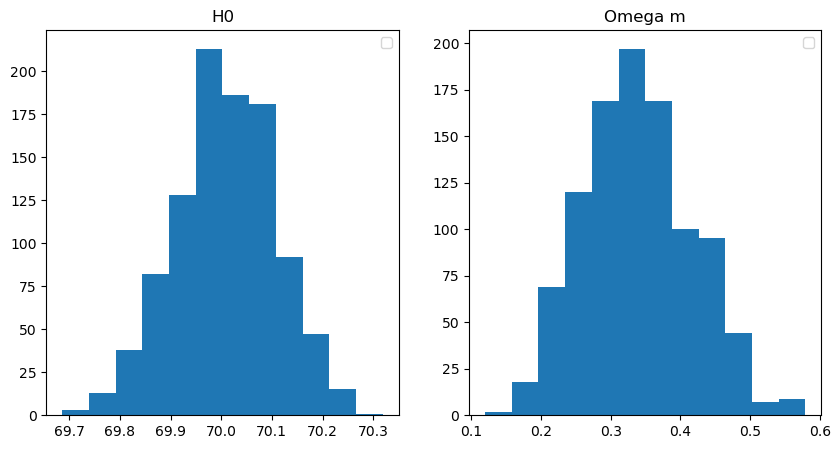

In [193]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a_list, bins=12)
#plt.vlines(peak_a, ymin=0, ymax=300, colors="r", label=f"best fit value {peak_a}")
plt.title('H0')
plt.legend()

plt.subplot(1,2,2)
plt.hist(b_list, bins=12)
#plt.vlines(peak_b, ymin=0, ymax=300, colors="r", label=f"best fit value {peak_b}")
plt.title('Omega m')
plt.legend()


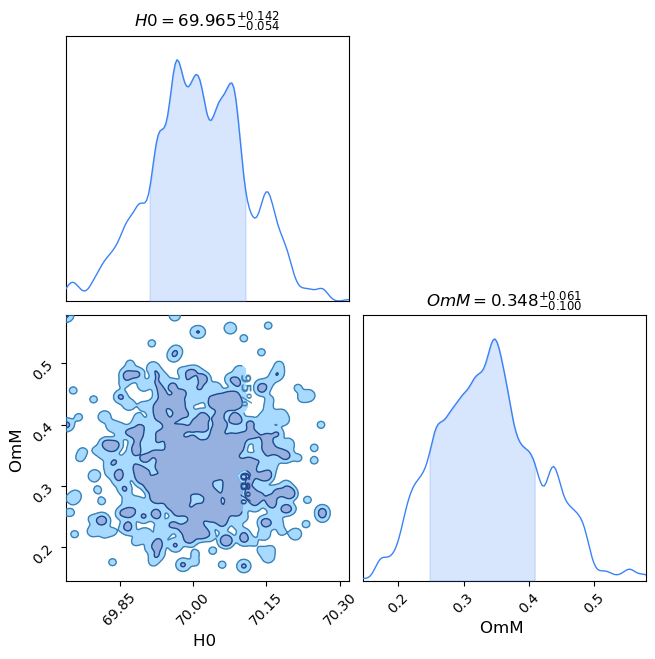

In [192]:
from chainconsumer import Chain, ChainConsumer, make_sample, PlotConfig

df = pd.DataFrame({"H0":a_list, "OmM":b_list})
c = ChainConsumer()
c.add_chain(Chain(
    samples=df, 
    name="Pantheon SNla", 
    show_contour_labels=True,))
fig = c.plotter.plot()